In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import ipynb.fs

In [2]:
from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, getFilteredTrials, getTrials, psd, plot_psd,
                                                logvar, plot_logvar, apply_mix, csp, scatter, featureExtraction)


**Data Exploration**

The following sections explores the given dataset, in search for information needed to create a model to discriminate between left and right hand imagination. We will focus our efforts on signals within the frequency range of 8-12 Hz recorded at the motor cortex. These refer to sensorimotor mu rythm (mu waves). According to the literature, mu rythm suppression is observed when motor functions are performed. 

In [3]:
#Load dataset using scipy.io's loadmat function
# Looking at the structure in MATLAB provides a good map for locating relevant data
# loadmat returns a dict 

data = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat")

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cnt', 'mrk', 'nfo'])

"cnt" : the continuous EEG signals, size = [time x channels]. The array is stored in datatype INT16. To convert it to uV values, use cnt= 0.1*double(cnt).

"mrk" : a matlab structure of target cue information with fields;
    pos: vector of positions of the cue in the EEG signals given in unit sample, length #cues
    y: vector of target classes (-1 for class one or 1 for class two), length #cues

"nfo" : a matlab structure providing additional information with fields;
    fs: sampling rate,
    clab: cell array of channel labels,
    classes: cell array of the names of the motor imagery classes,
    xpos: x-position of electrodes in a 2d-projection,
    ypos: y-position of electrodes in a 2d-projection.

In [5]:
data["cnt"] = 0.1 * data["cnt"].astype(float)

eeg = data["cnt"].T

nChannels, nSamples = eeg.shape


In [6]:
# plt.figure(figsize=(16,8))
# plt.plot(eeg.T)


In [7]:
# A plot of time-voltage values for all 59 channels
# fig, axes = plt.subplots(nChannels, sharex = True, figsize=(30,100))
# for i in range(nChannels):
#     axes[i].plot(eeg.T[:,i])
#     axes[i].label_outer()

The above shows the relevant EEG data contained in a numpy array for 190K+ rows (samples) and 59 columns (features/channels)

In [8]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(data,nSamples)

In [9]:
print(f"Shape of data: {eeg.shape}")
print(f"Number of channels: {nChannels}")
print(f"Channel names: {channelNames}")
print(f"Sampling frequency: {sRate}")
print(f"Number of events: {len(eventCodes[0])}")
print(f"Event codes: {np.unique(eventCodes)}")
print(f"Class labels: {classLabels}")

Shape of data: (59, 1905940)
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Sampling frequency: 1000
Number of events: 200
Event codes: [-1  1]
Class labels: ['left', 'foot']


In [10]:
cl1, cl2 = classLabels

In [11]:
trialWindow = np.arange(int(0*sRate),int(4*sRate))

In [12]:
trials, idleStateTrials = getTrials(classLabels,np.unique(eventCodes),trialWindow,eeg,eventCodes,eventOnsets,sRate,nChannels)

In [13]:
print(f"Shape of trials of class left: {trials[cl1].shape}")
print(f"Shape of trials of class right: {trials[cl2].shape}")


Shape of trials of class left: (59, 100, 4000)
Shape of trials of class right: (59, 100, 4000)


trial per class ---> [
                        [CHANNEL 1] ----> [[TRIAL ONSET SAMPLE 1] ----> [[Time sample 1]
                                                                         [Time sample 2]
                                                                         [Time Sample 3]
                                                                         .
                                                                         .
                                                                         .
                                                                         .
                                                                         [Time sample 200] 
                                                                        ]
                                        [TRIAL ONSET SAMPLE 2]
                                        [TRIAL ONSET SAMPLE 3]
                                        .
                                        .
                                        .
                                        .
                                        [TRIAL ONSET SAMPLE 100]
                                        ]
                        [CHANNEL 2]
                        [CHANNEL 3]
                        .
                        .
                        .
                        .
                        .
                        [CHANNEL 59]

                     ]

Given the current task of classifying signals into left or right hand motor signals, the first focus point must be finding discriminating features between these signals. From experimentation and observation, the phenomenon of event related desynchronisation (ERD) has proven to be a good indicator of motor-imagination/control in along the primary sensorimotor area of relevant hemispheres of the brain.

ERD is a phenomenon which is characterized by a decrease (when compared to a baseling) in signal power during an experimental condition [ref = Event-related (De)synchronization (ERD/ERS) during motor imagery tasks: Implications for brainecomputer interfaces].
It can be seen that during motor imagery, Mu rhythms display an event-related desychronization only over the contralateral hemisphere [ref = Motor imagery activates primary sensorimotor area in humans], further supporting the idea in neurophysiology of contralateral motor control. 

To confirm this ERD phenomenom as a useful feature for classifying motor signals, a plot of the power spectral density of signals from the sensorimotor area (channels C3 and C4 for left and right hemisphere respectively) within the frequency band of interest is utilized. 


In [14]:
psd_l,freqs = psd(trials[cl1], trialWindow, nChannels, sRate)
psd_r,freqs = psd(trials[cl2], trialWindow, nChannels, sRate)


We must now compare the difference in power between idle state trials and motion intent state trials

Steps
-----
1. Concatenate left and right idle state trials into one super class
2. Concatenate left and right motion intent state trials into one super class 
3. Plot psd 

In [15]:
psd_idle,freqs_idle = psd(np.concatenate([idleStateTrials[cl1],idleStateTrials[cl2]], axis=1), trialWindow, nChannels, sRate)
psd_motion,freqs_motion = psd(np.concatenate([trials[cl1],trials[cl2]], axis=1), trialWindow, nChannels, sRate)


In [16]:
psd_l.shape

(59, 100, 2001)

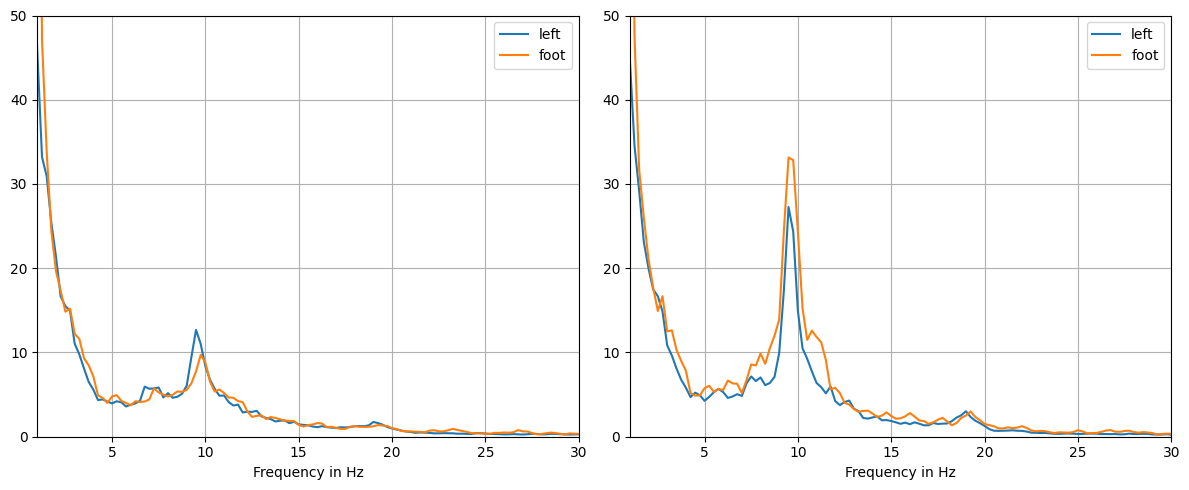

In [17]:
plot_psd({cl1:psd_l,cl2:psd_r},freqs,[channelNames.index(ch) for ch in ["C3","C4"]],50)

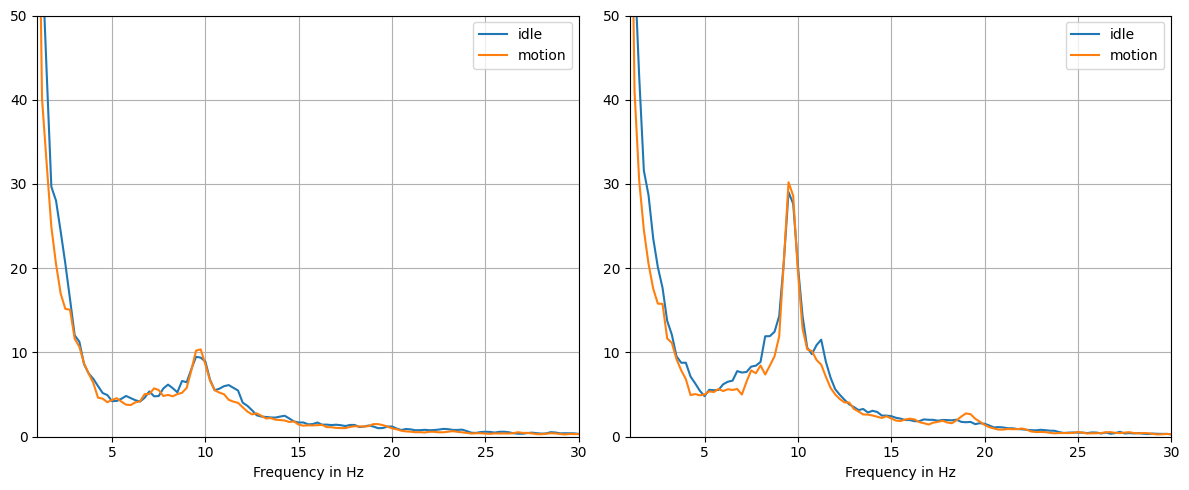

In [18]:
plot_psd({cl1:psd_idle,cl2:psd_motion},freqs_idle,[channelNames.index(ch) for ch in ["C3","C4"]],50,["idle", "motion"])

In the plot above, the PSD of signals associated with right hand movement 

#Filtering signal to focus on frequency band of interest

The Mu rhythm is characterized activity falling in the 8 - 12 Hz range over central and central-parietal electrodes in humans. [ref = Amplitude of Sensorimotor Mu Rhythm Is Correlated with BOLD from Multiple Brain Regions: A Simultaneous EEG-fMRI Study]. Owing to the information, we apply a bandpass filter in order to obtain signals within this frequency range alone.

In [19]:
trials_filt = getFilteredTrials(trials,trialWindow,nChannels,sRate,classLabels=classLabels)
idleStateTrials_filt = getFilteredTrials(idleStateTrials,trialWindow, nChannels, sRate, classLabels=classLabels)


In [20]:
psd_l_filt,freqs_filt = psd(trials_filt[cl1],trialWindow, nChannels, sRate)
psd_r_filt,freqs_filt = psd(trials_filt[cl2], trialWindow, nChannels, sRate)


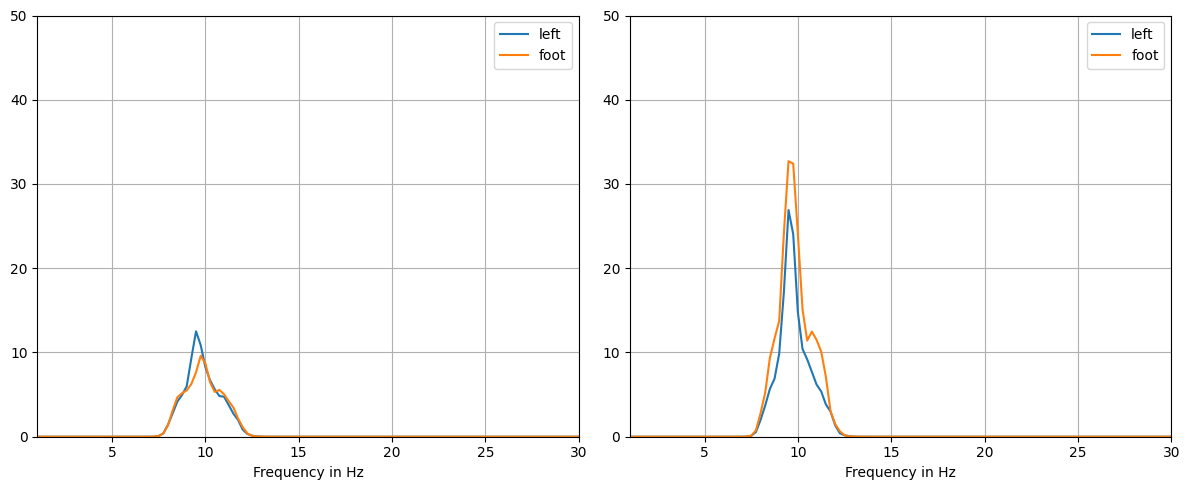

In [21]:
plot_psd({cl1:psd_l_filt,cl2:psd_r_filt},freqs_filt,[channelNames.index(ch) for ch in ["C3","C4"]],50)

In [22]:
psd_l_filt_idle,freqs_filt_idle = psd(np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1),trialWindow, nChannels, sRate)
psd_r_filt_motion,freqs_filt_motion = psd(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1), trialWindow, nChannels, sRate)


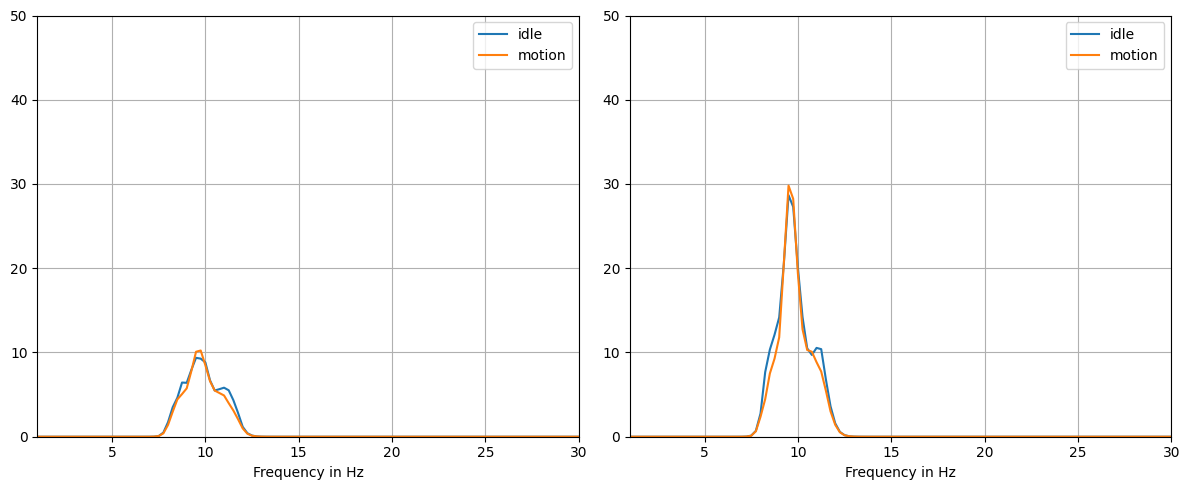

In [23]:
plot_psd({cl1:psd_l_filt_idle,cl2:psd_r_filt_motion},freqs_filt_idle,[channelNames.index(ch) for ch in ["C3","C4"]],50,["idle","motion"])

Using Common Spatial Patterns Algorithm to maximize the variance between classes 

In [24]:
#Following the standard bci classification paradigm outlined in "The non-invasive Berlin Brain–Computer Interface: Fast acquisition of effective performance in untrained subjects"
#Benjamin Blankertz,a,⁎ Guido Dornhege,a Matthias Krauledat,a,b Klaus-Robert Müller, and Gabriel Curio

In [25]:
trials_logvar = {cl1:logvar(trials_filt[cl1]),
                 cl2:logvar(trials_filt[cl2])
                }

In [26]:
idleMotionStateTrials_logvar = {cl1:logvar(np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1)),
                          cl2:logvar(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1))}


In [27]:
trials_logvar[cl1].shape

(59, 100)

In [28]:
idleMotionStateTrials_logvar[cl1].shape

(59, 200)

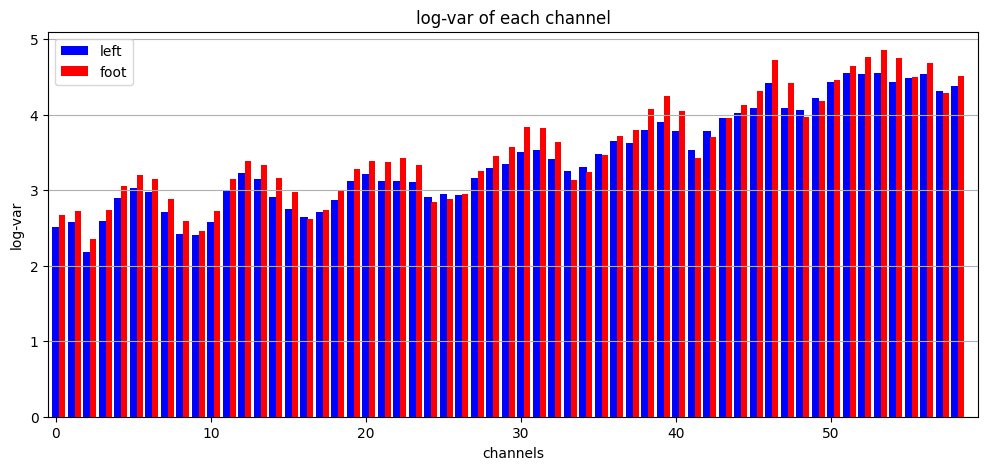

In [29]:
plot_logvar(trials_logvar,nChannels, classLabels)
#This is a plot of log of the average variance for each channel for both left and right hand signals. 
# There seems to some difference between the two for each channel but the this difference is not large 
# enough for log-var to be considered a discriminating feature.

#If the difference were greater, we could train a classifier to compare the log var of a singal 
# in the given time window of interest with the average log of the average variance as shown below

#We need to find a way to transform the signals so as to increase discriminable information

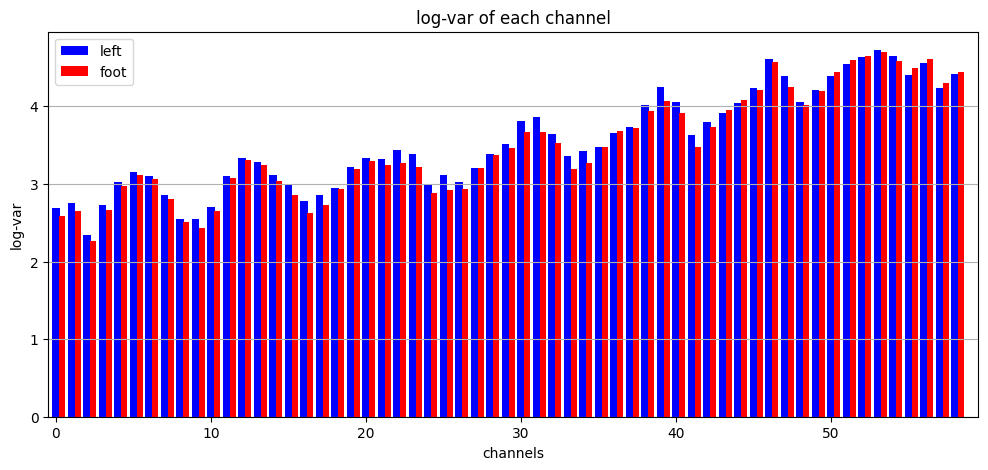

In [30]:
plot_logvar(idleMotionStateTrials_logvar,nChannels, classLabels)


In [31]:
W = csp(trials_filt[cl2],trials_filt[cl1])

In [32]:
W_idleState = csp(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1),np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1) )


In [33]:
W

array([[-0.12914891,  0.10425796, -0.00881821, ...,  0.04852256,
         0.03009394, -0.0118819 ],
       [ 0.10317875, -0.19099227,  0.20367764, ..., -0.02171534,
        -0.03480383,  0.02263522],
       [ 0.18338479,  0.00894416, -0.07941697, ..., -0.05185455,
        -0.01616591,  0.12626768],
       ...,
       [-0.02678814, -0.04594326, -0.07029555, ...,  0.04981135,
        -0.19941167,  0.01468797],
       [ 0.01579055,  0.00464971,  0.01221598, ...,  0.09380366,
        -0.10979934,  0.0017096 ],
       [ 0.01344569, -0.01615351,  0.00129879, ..., -0.08332698,
         0.06081894,  0.03111301]])

In [34]:
W_idleState

array([[ 1.21600629e-02,  5.80349444e-02,  3.11942977e-01, ...,
        -1.74541848e-01,  4.14542550e-02, -5.90030072e-02],
       [ 8.38178266e-02, -7.67599270e-03, -1.29264360e-01, ...,
         9.72655809e-02, -6.10024327e-02,  2.77788214e-02],
       [ 3.96399030e-02, -1.38726864e-01, -1.94136662e-01, ...,
         7.42767856e-02, -8.70141345e-02,  9.73508860e-02],
       ...,
       [ 6.21399270e-03,  1.70546135e-01,  1.46066523e-01, ...,
         3.69110020e-02, -3.11412203e-02,  6.19889824e-05],
       [ 1.58169200e-02,  1.90225771e-02,  5.32403462e-02, ...,
        -3.08304069e-02, -1.84149260e-02, -1.55296223e-02],
       [ 1.30968825e-04, -3.19116568e-02, -9.02066323e-02, ...,
         1.79072116e-02,  6.55834825e-03,  9.61212579e-03]])

In [35]:
trials_csp = {
    cl1 : apply_mix(W,trials_filt[cl1], trialWindow, nChannels),
    cl2 : apply_mix(W,trials_filt[cl2], trialWindow, nChannels)
}

#When you transform data using the weight matrix generated by the CSP algorithm,
#you are applying these spatial filters to the data. The resulting transformed data
# is a new set of features that can be used for classification.


In [36]:
idleStateTrials_csp = {
    cl1 : apply_mix(W_idleState,np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1), trialWindow, nChannels),
    cl2 : apply_mix(W_idleState,np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1), trialWindow, nChannels)
}


In [37]:
trials_csp[cl1].shape

(59, 100, 4000)

In [38]:
idleStateTrials_csp[cl1].shape

(59, 200, 4000)

In [39]:
trials_logvar = {
    cl1: logvar(trials_csp[cl1]),
    cl2:logvar(trials_csp[cl2])
}

In [40]:
idleStateTrials_logvar = {
    cl1: logvar(idleStateTrials_csp[cl1]),
    cl2:logvar(idleStateTrials_csp[cl2])
}


In [41]:
trials_logvar[cl1].shape

(59, 100)

In [42]:
idleStateTrials_logvar[cl1].shape

(59, 200)

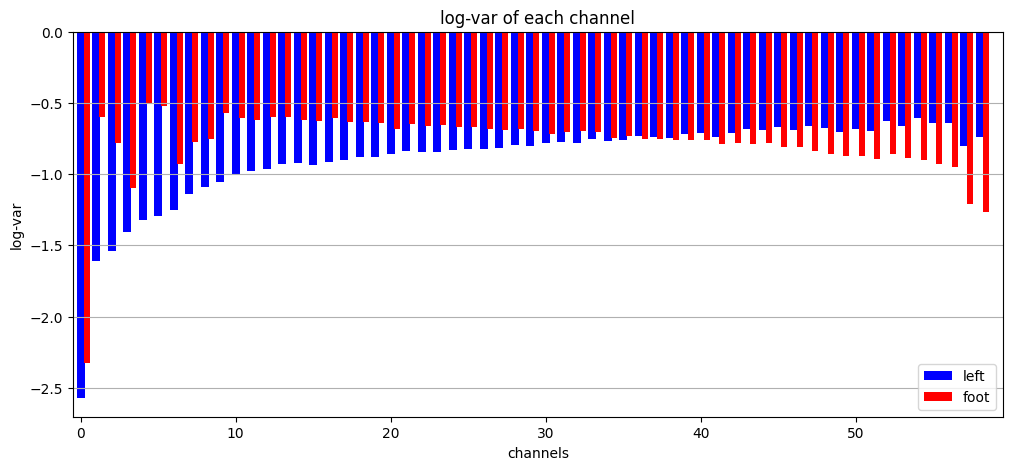

In [43]:
plot_logvar(trials_logvar,nChannels, classLabels)

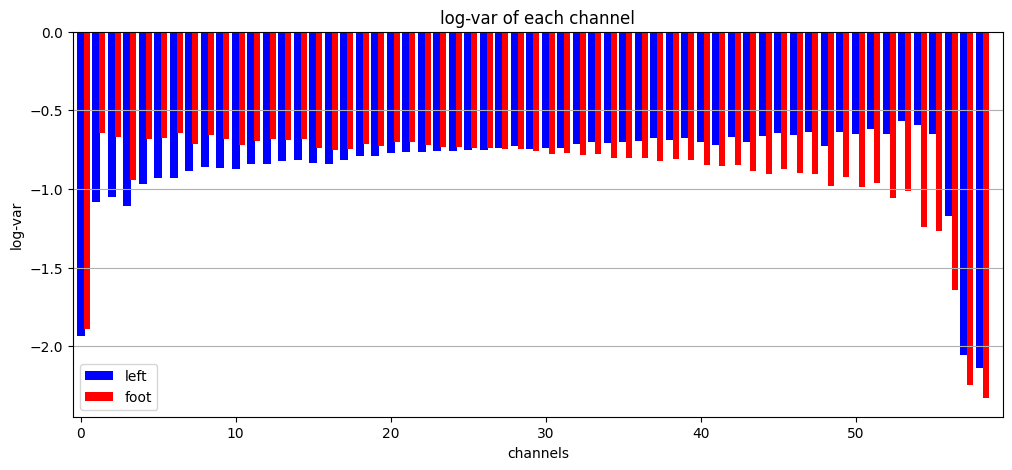

In [44]:
plot_logvar(idleStateTrials_logvar,nChannels, classLabels)


We now create a scatter plot function to enable us to better visualise the difference between the first csp component and the last csp component, i.e, the most varied combination of channels between the two classes.

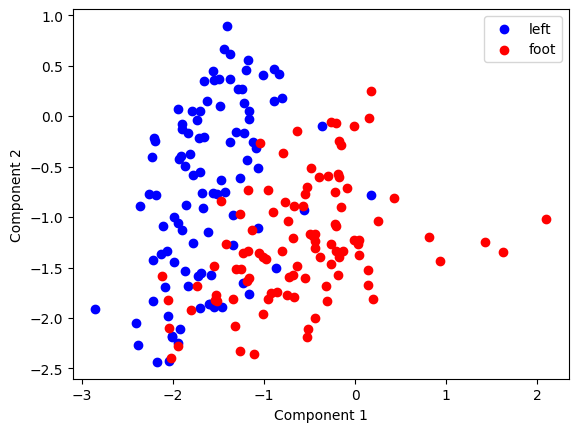

In [45]:
scatter(trials_logvar[cl1],trials_logvar[cl2],["left","foot"],[1,-1])


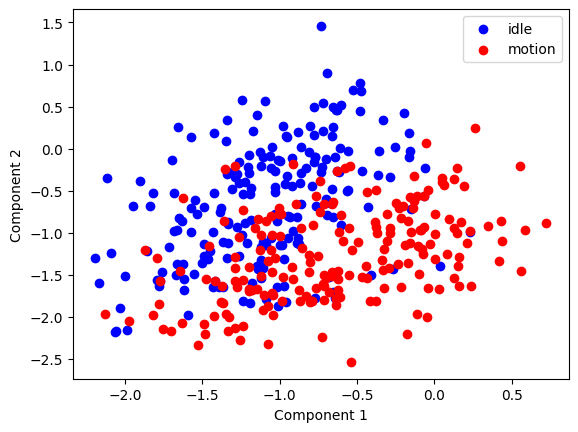

In [46]:
scatter(idleStateTrials_logvar[cl1],idleStateTrials_logvar[cl2],["idle","motion"],[1,-4])


In [48]:
#Justifying my use of LDA
#Plot plot the distribution for each of the predictors in the dataframe
#If the distribution of the predictors X is approximately normal
#in each of the classes and the sample size is small, then the approaches 
#in this section may be more accurate than logistic regression.

data_A_df_train, data_A_df_test, _ = featureExtraction(data,0.7,[1,-1], [1,-4])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Multivariate Normality Test

In [97]:
import pingouin as pg
pg.multivariate_normality(data_A_df_train["None"].iloc[:,:2], alpha=.05)


HZResults(hz=1.8955061161486149, pval=0.000199452833952155, normal=False)

In [98]:
data_A_df_train_idle, _, _ = featureExtraction(data,0.7,[1,-1], [1,-4],ExtractionType="idle_motionIntent")


In [99]:
pg.multivariate_normality(data_A_df_train_idle.iloc[:,:2], alpha=.05)


HZResults(hz=12.200621386142535, pval=1.3720398037715595e-21, normal=False)